# Problem Session 6
## The Simpsons II

In the second of two time series based problem sessions we build upon Problem Session 5. In particular, we will build more complicated forecasts on our Simpsons data.

The problems in this notebook will cover the content covered in our `Time Series Forecasting` lectures including:
- `Averaging and Smoothing`,
- `Stationarity and Autocorrelation` and
- `ARIMA`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

### The Simpsons

##### 1. Refresher

Recall that the data stored in `simpsons_imdb.csv` gives the IMDB rating for every episode of the Simpsons up to May 6, 2022. Our goal with this data set is to build a forecast that predicts the rating of an episode, given its number in the run of the Simpsons.

Load `simpsons_imdb.csv` from the `Data` folder, then set aside the last season as a test set.

##### Sample Solution

In [2]:
simpsons = pd.read_csv("../Data/simpsons_imdb.csv")

In [3]:
simps_train = simpsons.loc[simpsons.season != 33].copy()
simps_test = simpsons.drop(simps_train.index)

Plot the training set data using a scatter plot.

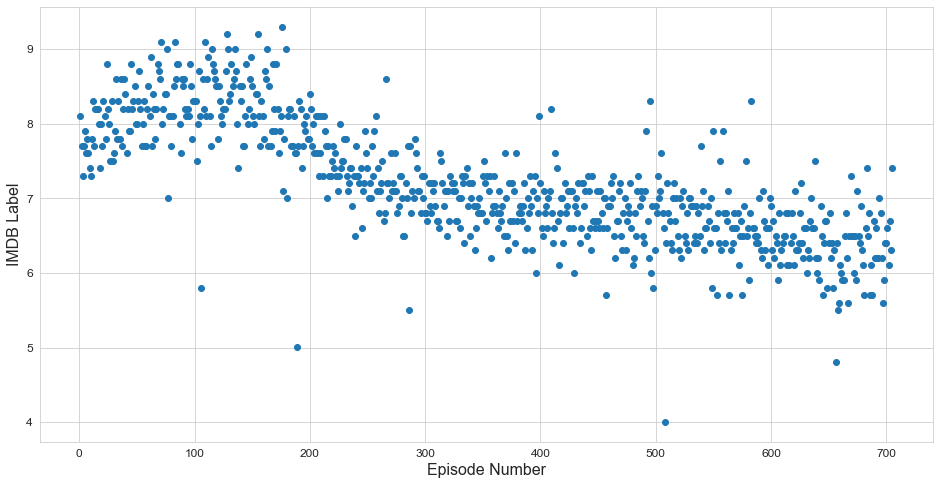

In [4]:
plt.figure(figsize=(16,8))

plt.scatter(range(1, len(simps_train)+1), simps_train.imdb_rating)

plt.xlabel("Episode Number", fontsize=16)
plt.ylabel("IMDB Label", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In the previous problem session you built two baseline forecasts on these data. In this notebook we will build two of our more complex models.

##### 2. A moving average model

The first forecast we will try is the moving average forecast. 

Fill in the missing pieces of code below to run a time series cross-validation to find the moving average window size, $q$, that minimizes the average cross-validation mean squared error.

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [6]:
cv = TimeSeriesSplit(5, test_size=11)

start = 2
end = 31
ma_mses = np.zeros((5, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(simps_train):
    simps_tt = simps_train.loc[train_index]
    simps_ho = simps_train.loc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = simps_tt.imdb_rating[-q:].mean() * np.ones(len(simps_ho))
        
        ma_mses[i,j] = mean_squared_error(simps_ho.imdb_rating.values, pred)
        j = j + 1
    i = i + 1

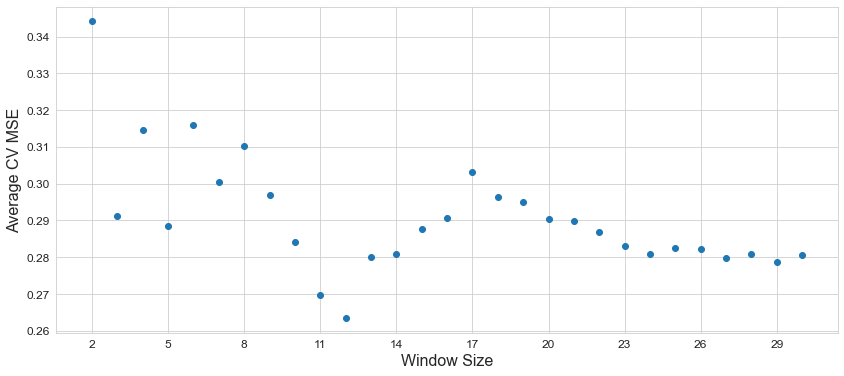

In [7]:
plt.figure(figsize=(14,6))

plt.scatter(range(start,end), np.mean(ma_mses, axis=0))

plt.xlabel("Window Size", fontsize=16)
plt.ylabel("Average CV MSE", fontsize=16)

plt.xticks(range(start, end, 3), fontsize=12)
plt.yticks(fontsize=12)

plt.show()
            

In [8]:
print("The window size that minimized the avg. cv mse",
      "was q =", range(start,end)[np.argmin(np.mean(ma_mses, axis=0))],"."
      "It had a mean cv mse of", np.round(np.min(np.mean(ma_mses, axis=0)), 3))

The window size that minimized the avg. cv mse was q = 12 .It had a mean cv mse of 0.263


##### 3. An exponential smoothing forecast

Because this data has a trend, but not seasonality we will fit a double exponential smoothing model. For this we will want to find the best $\alpha$ (The smoothing on the time series) and $\beta$ (the smoothing on the trend component).

Fill in the missing code chunks below to perform a grid search for the values of $\alpha$ and $\beta$ that minimize the average CV MSE.

In [9]:
from statsmodels.tsa.holtwinters import Holt

In [10]:
exp_mses = np.zeros((5, len(np.arange(0, 0.2, .01)), len(np.arange(0, 0.2, .01))))

i = 0
for train_index, test_index in cv.split(simps_train):
    simps_tt = simps_train.loc[train_index]
    simps_ho = simps_train.loc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.2, .01):
        k = 0
        for beta in np.arange(0, 0.2, .01):
        

            exp_smooth = Holt(simps_tt.imdb_rating.values).fit(smoothing_level=alpha, 
                                                                      smoothing_trend=beta,
                                                                      optimized=False)

            exp_mses[i,j,k] = mean_squared_error(simps_ho.imdb_rating.values, exp_smooth.forecast(len(simps_ho)))
            k = k + 1
        j = j + 1
    i = i + 1

In [11]:
## This gives us the indices of the smallest
## avg cv mse
exp_ind = np.unravel_index(np.argmin(np.mean(exp_mses, axis=0), axis=None), np.mean(exp_mses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_mses, axis=0), axis=None), np.mean(exp_mses, axis=0).shape)

(1, 11)

In [12]:
print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv mse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(exp_mses, axis=0)[exp_ind],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv mse are alpha =  0.01 and beta =  0.11
This model had an avg cv mse of 0.237


##### 4. An ARIMA model

The final model we will build is an ARIMA model.

##### a. Stationarity check

First let's check if our series clearly breaks the stationarity assumption of ARIMA models. Make an autocorrelation plot of the training data.

In [13]:
import statsmodels.api as sm

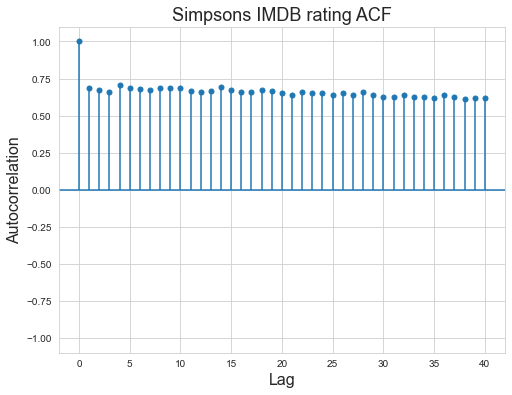

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sm.graphics.tsa.plot_acf(simps_train.imdb_rating.values,
                            alpha=None,
                            lags = 40,
                            ax = ax)

plt.title('Simpsons IMDB rating ACF', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

If you find that the ACF plot indicates that the time series is non-stationary, plot the ACF of the time series' first differences. Do these appear to be stationary?

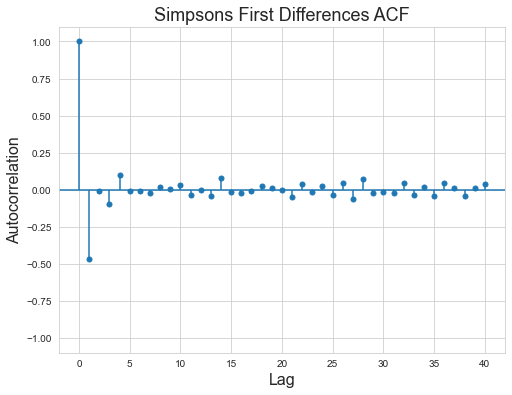

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

sm.graphics.tsa.plot_acf(simps_train.imdb_rating.diff().values[1:],
                               alpha=None,
                               lags=40,
                               ax=ax)

plt.title('Simpsons First Differences ACF', fontsize=18)
plt.ylabel("Autocorrelation", fontsize=16)
plt.xlabel("Lag", fontsize=16)

plt.ylim(-1.1,1.1)

plt.show()

Yes they do!

##### b. Fitting the model

From what we saw above we should set our $d$ value in the ARIMA model to $1$. This leaves us the $p$ and $q$ arguments to select. Fill in the missing code in the chunks below to perform a grid search that gives us the $p$ and $q$ values with the lowest avg. CV MSE.

In [16]:
from statsmodels.tsa.api import SARIMAX

In [17]:
arima_mses = np.zeros((5, 4, 4))

i = 0
for train_index, test_index in cv.split(simps_train):
    simps_tt = simps_train.loc[train_index]
    simps_ho = simps_train.loc[test_index]
    
    j = 0
    for p in range(1,5):
        k = 0
        for q in range(1,5):
            arima = SARIMAX(simps_tt.imdb_rating.values,
                               order=(p, 1, q)).fit(maxiter=500)
            
            arima_mses[i,j,k] = mean_squared_error(simps_ho.imdb_rating.values, arima.forecast(len(simps_ho)))
            k = k +1
        j = j + 1
    i = i +1

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83905D-01    |proj g|=  2.09368D-01

At iterate    5    f=  6.59779D-01    |proj g|=  3.04252D-02

At iterate   10    f=  6.47904D-01    |proj g|=  3.65095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     16      1     0     0   3.053D-05   6.479D-01
  F =  0.64790250082956224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.47863D-01    |proj g|=  2.99009D-04

At iterate   15    f=  6.47852D-01    |proj g|=  3.85864D-03

At iterate   20    f=  6.46809D-01    |proj g|=  9.25860D-02

At iterate   25    f=  6.41328D-01    |proj g|=  2.07788D-02

At iterate   30    f=  6.37558D-01    |proj g|=  4.53140D-02

At iterate   35    f=  6.36027D-01    |proj g|=  1.24746D-02

At iterate   40    f=  6.35336D-01    |proj g|=  3.45665D-03

At iterate   45    f=  6.35214D-01    |proj g|=  1.56142D-03

At iterate   50    f=  6.35214D-01    |proj g|=  4.79449D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     65   

 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.38414D-01    |proj g|=  2.79970D-03

At iterate   20    f=  6.38398D-01    |proj g|=  3.90998D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   1.354D-05   6.384D-01
  F =  0.63839752784962145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40956D+00    |proj g|=  2.69616D+00

At iterate    5    f=  7.20005D-01    |proj g|=  9.60323D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  6.46325D-01    |proj g|=  1.87049D-02

At iterate   20    f=  6.45260D-01    |proj g|=  2.70371D-02

At iterate   25    f=  6.45183D-01    |proj g|=  3.08583D-04

At iterate   30    f=  6.45179D-01    |proj g|=  1.53899D-03

At iterate   35    f=  6.44373D-01    |proj g|=  5.80070D-02

At iterate   40    f=  6.41282D-01    |proj g|=  5.07189D-02

At iterate   45    f=  6.39977D-01    |proj g|=  3.50704D-02

At iterate   50    f=  6.39249D-01    |proj g|=  1.68772D-02

At iterate   55    f=  6.38974D-01    |proj g|=  1.68355D-03

At iterate   60    f=  6.38973D-01    |proj g|=  5.93872D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.39089D-01    |proj g|=  5.02247D-03

At iterate   10    f=  6.38984D-01    |proj g|=  3.34060D-03

At iterate   15    f=  6.38657D-01    |proj g|=  4.41210D-02

At iterate   20    f=  6.38489D-01    |proj g|=  4.07533D-04

At iterate   25    f=  6.38456D-01    |proj g|=  3.59412D-03

At iterate   30    f=  6.38398D-01    |proj g|=  1.17460D-03

At iterate   35    f=  6.38395D-01    |proj g|=  8.59211D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     40      1     0     0   1.244D-05   6.384D-01
  F =  0.63839480247900937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  6.39139D-01    |proj g|=  5.23031D-03

At iterate   25    f=  6.39096D-01    |proj g|=  9.22432D-03

At iterate   30    f=  6.38642D-01    |proj g|=  6.11668D-03

At iterate   35    f=  6.38548D-01    |proj g|=  7.70477D-04

At iterate   40    f=  6.38535D-01    |proj g|=  2.69061D-04

At iterate   45    f=  6.38535D-01    |proj g|=  5.31092D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     53      1     0     0   1.999D-05   6.385D-01
  F =  0.63853473257215210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  6.38175D-01    |proj g|=  1.09741D-02

At iterate   25    f=  6.37338D-01    |proj g|=  2.45654D-02

At iterate   30    f=  6.37150D-01    |proj g|=  1.39019D-03

At iterate   35    f=  6.37130D-01    |proj g|=  2.18395D-04

At iterate   40    f=  6.37130D-01    |proj g|=  3.53828D-04

At iterate   45    f=  6.37126D-01    |proj g|=  1.74768D-03

At iterate   50    f=  6.37124D-01    |proj g|=  1.51114D-03

At iterate   55    f=  6.37123D-01    |proj g|=  9.36352D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     55     64      1     0     0   9.364D-05   6.371D-01
  F =  0.637123499328

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  6.38246D-01    |proj g|=  1.42939D-03

At iterate   30    f=  6.38244D-01    |proj g|=  1.13354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     37      1     0     0   5.309D-06   6.382D-01
  F =  0.63824408359513141     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.51533D-01    |proj g|=  1.06447D-01

At iterate    5    f=  6.44240D-01    |proj g|=  2.69612D-02

At iter

 This problem is unconstrained.



At iterate   40    f=  6.38333D-01    |proj g|=  7.36722D-03

At iterate   45    f=  6.38267D-01    |proj g|=  4.58133D-03

At iterate   50    f=  6.38218D-01    |proj g|=  8.14521D-04

At iterate   55    f=  6.38188D-01    |proj g|=  7.57787D-03

At iterate   60    f=  6.38121D-01    |proj g|=  2.08613D-03

At iterate   65    f=  6.38115D-01    |proj g|=  1.29156D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     68     79      1     0     0   9.179D-06   6.381D-01
  F =  0.63811459382725899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  6.38513D-01    |proj g|=  2.78540D-03

At iterate   15    f=  6.38388D-01    |proj g|=  1.82615D-03

At iterate   20    f=  6.38356D-01    |proj g|=  8.53416D-03

At iterate   25    f=  6.37491D-01    |proj g|=  1.39742D-02

At iterate   30    f=  6.37206D-01    |proj g|=  3.52230D-03

At iterate   35    f=  6.37126D-01    |proj g|=  2.46907D-03

At iterate   40    f=  6.37124D-01    |proj g|=  5.61105D-04

At iterate   45    f=  6.37123D-01    |proj g|=  4.60443D-04

At iterate   50    f=  6.37123D-01    |proj g|=  2.92386D-04

At iterate   55    f=  6.37121D-01    |proj g|=  4.96400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81594D-01    |proj g|=  1.12086D-01

At iterate    5    f=  6.55343D-01    |proj g|=  3.66657D-02

At iterate   10    f=  6.54090D-01    |proj g|=  3.21584D-04

At iterate   15    f=  6.54069D-01    |proj g|=  1.00786D-02

At iterate   20    f=  6.53853D-01    |proj g|=  6.62003D-03

At iterate   25    f=  6.53479D-01    |proj g|=  1.31541D-02

At iterate   30    f=  6.53280D-01    |proj g|=  3.25492D-03

At iterate   35    f=  6.53214D-01    |proj g|=  6.67609D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.46339D-01    |proj g|=  2.12770D-04

At iterate   15    f=  6.46334D-01    |proj g|=  4.85515D-03

At iterate   20    f=  6.46318D-01    |proj g|=  1.23231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   1.239D-05   6.463D-01
  F =  0.64631760171803199     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40705D+00    |proj g|=  2.67218D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.46580D-01    |proj g|=  4.33776D-03

At iterate   10    f=  6.46552D-01    |proj g|=  2.05574D-03

At iterate   15    f=  6.46412D-01    |proj g|=  1.00350D-02

At iterate   20    f=  6.46313D-01    |proj g|=  3.18358D-04

At iterate   25    f=  6.46297D-01    |proj g|=  1.88727D-03

At iterate   30    f=  6.46283D-01    |proj g|=  1.36148D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     40      1     0     0   7.909D-06   6.463D-01
  F =  0.64628305639345918     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  6.73217D-01    |proj g|=  1.05604D-01

At iterate   15    f=  6.47118D-01    |proj g|=  2.12676D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   5.868D-06   6.470D-01
  F =  0.64704649448886764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63296D-01    |proj g|=  1.31207D-01

At iterate    5    f=  6.51288D-01    |proj g|=  3.24457D-02

At itera

 This problem is unconstrained.



At iterate   15    f=  6.45913D-01    |proj g|=  1.55220D-03

At iterate   20    f=  6.45702D-01    |proj g|=  2.36023D-02

At iterate   25    f=  6.44734D-01    |proj g|=  2.12932D-02

At iterate   30    f=  6.44556D-01    |proj g|=  5.89714D-03

At iterate   35    f=  6.44506D-01    |proj g|=  3.51854D-04

At iterate   40    f=  6.44505D-01    |proj g|=  4.37503D-04

At iterate   45    f=  6.44494D-01    |proj g|=  5.71650D-03

At iterate   50    f=  6.44477D-01    |proj g|=  5.36216D-03

At iterate   55    f=  6.44465D-01    |proj g|=  3.06916D-04

At iterate   60    f=  6.44463D-01    |proj g|=  2.40129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.46524D-01    |proj g|=  1.28237D-02

At iterate   15    f=  6.46356D-01    |proj g|=  8.09571D-05

At iterate   20    f=  6.46354D-01    |proj g|=  8.16398D-04

At iterate   25    f=  6.46343D-01    |proj g|=  1.51579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     35      1     0     0   8.223D-06   6.463D-01
  F =  0.64634194790837118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  6.46628D-01    |proj g|=  8.84032D-03

At iterate   25    f=  6.46278D-01    |proj g|=  2.30009D-03

At iterate   30    f=  6.46269D-01    |proj g|=  1.41204D-04

At iterate   35    f=  6.46263D-01    |proj g|=  2.57432D-03

At iterate   40    f=  6.46172D-01    |proj g|=  7.64724D-03

At iterate   45    f=  6.46138D-01    |proj g|=  2.78931D-03

At iterate   50    f=  6.46107D-01    |proj g|=  2.93459D-04

At iterate   55    f=  6.46106D-01    |proj g|=  5.13465D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     58     70      1     0     0   2.957D-05   6.461D-01
  F =  0.646106312219

 This problem is unconstrained.



At iterate    5    f=  6.46149D-01    |proj g|=  8.44606D-03

At iterate   10    f=  6.46111D-01    |proj g|=  3.60773D-03

At iterate   15    f=  6.45950D-01    |proj g|=  7.68625D-03

At iterate   20    f=  6.45895D-01    |proj g|=  3.05005D-03

At iterate   25    f=  6.45413D-01    |proj g|=  4.30004D-02

At iterate   30    f=  6.44643D-01    |proj g|=  1.40952D-02

At iterate   35    f=  6.44544D-01    |proj g|=  1.80234D-03

At iterate   40    f=  6.44540D-01    |proj g|=  1.80619D-04

At iterate   45    f=  6.44540D-01    |proj g|=  3.85862D-04

At iterate   50    f=  6.44537D-01    |proj g|=  2.18209D-03

At iterate   55    f=  6.44504D-01    |proj g|=  2.79857D-03

At iterate   60    f=  6.44474D-01    |proj g|=  3.05070D-03

At iterate   65    f=  6.44465D-01    |proj g|=  9.02365D-04

At iterate   70    f=  6.44463D-01    |proj g|=  2.36535D-04

At iterate   75    f=  6.44463D-01    |proj g|=  8.83413D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     76     99      1     0     0   8.834D-05   6.445D-01
  F =  0.64446269024440439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.87977D-01    |proj g|=  2.01232D-01

At iterate    5    f=  6.65794D-01    |proj g|=  2.83809D-02

At iterate   10    f=  6.55052D-01    |proj g|=  4.82309D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.53535D-01    |proj g|=  5.33418D-02

At iterate   15    f=  6.52815D-01    |proj g|=  2.26363D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   1.628D-05   6.528D-01
  F =  0.65281542534863790     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.61442D-01    |proj g|=  1.73225D-01

At iterate    5    f=  6.55163D-01    |proj g|=  1.11109D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.52783D-01    |proj g|=  3.77573D-02

At iterate   20    f=  6.52072D-01    |proj g|=  1.20824D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     32      1     0     0   4.409D-05   6.521D-01
  F =  0.65206500252949895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48430D-01    |proj g|=  8.57169D-02

At iterate    5    f=  6.47298D-01    |proj g|=  8.35541D-03

At iter

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.73520D-01    |proj g|=  9.73624D-02

At iterate   15    f=  6.48022D-01    |proj g|=  2.06610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   8.809D-06   6.480D-01
  F =  0.64801296245143070     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.65267D-01    |proj g|=  1.25761D-01

At iterate    5    f=  6.52521D-01    |proj g|=  3.71672D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  6.45662D-01    |proj g|=  3.32450D-02

At iterate   25    f=  6.45161D-01    |proj g|=  6.35234D-03

At iterate   30    f=  6.45073D-01    |proj g|=  1.91215D-03

At iterate   35    f=  6.45063D-01    |proj g|=  4.54853D-04

At iterate   40    f=  6.45047D-01    |proj g|=  5.83301D-03

At iterate   45    f=  6.45013D-01    |proj g|=  7.06978D-03

At iterate   50    f=  6.44994D-01    |proj g|=  1.10240D-03

At iterate   55    f=  6.44991D-01    |proj g|=  6.42619D-04

At iterate   60    f=  6.44990D-01    |proj g|=  7.48649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     64     72   

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.59347D-01    |proj g|=  9.60557D-02

At iterate    5    f=  6.51501D-01    |proj g|=  3.92701D-02

At iterate   10    f=  6.48806D-01    |proj g|=  1.45737D-03

At iterate   15    f=  6.48685D-01    |proj g|=  1.06516D-02

At iterate   20    f=  6.47830D-01    |proj g|=  4.07418D-02

At iterate   25    f=  6.47223D-01    |proj g|=  5.05430D-03

At iterate   30    f=  6.47040D-01    |proj g|=  7.05252D-04

At iterate   35    f=  6.47039D-01    |proj g|=  2.13936D-04

At iterate   40    f=  6.47025D-01    |proj g|=  6.37635D-03

At iterate   45    f=  6.46958D-01    |proj g|=  1.03684D-02

At iterate   50    f=  6.46863D-01    |proj g|=  6.45612D-03

At iterate   55    f=  6.46796D-01    |proj g|=  1.56490D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function ev

 This problem is unconstrained.



At iterate   15    f=  6.46093D-01    |proj g|=  1.06419D-02

At iterate   20    f=  6.45971D-01    |proj g|=  2.42160D-03

At iterate   25    f=  6.45426D-01    |proj g|=  1.34815D-02

At iterate   30    f=  6.45107D-01    |proj g|=  2.97590D-03

At iterate   35    f=  6.45093D-01    |proj g|=  2.34993D-04

At iterate   40    f=  6.45089D-01    |proj g|=  1.35874D-03

At iterate   45    f=  6.45041D-01    |proj g|=  1.91781D-03

At iterate   50    f=  6.45018D-01    |proj g|=  1.60044D-03

At iterate   55    f=  6.45006D-01    |proj g|=  1.89612D-03

At iterate   60    f=  6.44992D-01    |proj g|=  1.50620D-03

At iterate   65    f=  6.44988D-01    |proj g|=  2.72477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90092D-01    |proj g|=  2.02184D-01

At iterate    5    f=  6.67678D-01    |proj g|=  2.80836D-02

At iterate   10    f=  6.57142D-01    |proj g|=  4.37543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   2.279D-05   6.571D-01
  F =  0.65713808746521218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.54776D-01    |proj g|=  2.86230D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   5.407D-05   6.548D-01
  F =  0.65477611234715660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.63286D-01    |proj g|=  1.68551D-01

At iterate    5    f=  6.57168D-01    |proj g|=  2.73418D-03

At iterate   10    f=  6.57121D-01    |proj g|=  1.55670D-04

At iter

 This problem is unconstrained.



At iterate   15    f=  6.54217D-01    |proj g|=  3.46569D-02

At iterate   20    f=  6.53988D-01    |proj g|=  7.14201D-03

At iterate   25    f=  6.53956D-01    |proj g|=  2.54195D-04

At iterate   30    f=  6.53950D-01    |proj g|=  7.65190D-03

At iterate   35    f=  6.53847D-01    |proj g|=  1.00206D-02

At iterate   40    f=  6.53658D-01    |proj g|=  1.18135D-02

At iterate   45    f=  6.53377D-01    |proj g|=  2.41653D-02

At iterate   50    f=  6.52862D-01    |proj g|=  3.29750D-02

At iterate   55    f=  6.52043D-01    |proj g|=  5.44613D-02

At iterate   60    f=  6.51539D-01    |proj g|=  3.93466D-02

At iterate   65    f=  6.51348D-01    |proj g|=  1.80716D-02

At iterate   70    f=  6.50988D-01    |proj g|=  4.28163D-02

At iterate   75    f=  6.50848D-01    |proj g|=  6.75142D-03

At iterate   80    f=  6.50788D-01    |proj g|=  1.40814D-02

At iterate   85    f=  6.50754D-01    |proj g|=  9.83111D-03

At iterate   90    f=  6.50580D-01    |proj g|=  3.01668D-02

At iter

 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  6.48855D-01    |proj g|=  4.58024D-03

At iterate   10    f=  6.48820D-01    |proj g|=  3.71333D-03

At iterate   15    f=  6.48678D-01    |proj g|=  2.20840D-03

At iterate   20    f=  6.48669D-01    |proj g|=  6.34014D-04

At iterate   25    f=  6.48648D-01    |proj g|=  3.03815D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     32      1     0     0   7.268D-06   6.486D-01
  F =  0.64864840918093425     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.49746D-01    |proj g|=  5.15856D-03

At iterate   20    f=  6.49262D-01    |proj g|=  1.08930D-02

At iterate   25    f=  6.49177D-01    |proj g|=  1.37949D-03

At iterate   30    f=  6.49008D-01    |proj g|=  2.11554D-02

At iterate   35    f=  6.48595D-01    |proj g|=  2.09395D-03

At iterate   40    f=  6.48575D-01    |proj g|=  2.28158D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     47      1     0     0   8.649D-06   6.486D-01
  F =  0.64857527753802025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate   15    f=  6.48266D-01    |proj g|=  1.29570D-03

At iterate   20    f=  6.48152D-01    |proj g|=  2.57731D-02

At iterate   25    f=  6.47114D-01    |proj g|=  8.29931D-03

At iterate   30    f=  6.46934D-01    |proj g|=  3.60940D-03

At iterate   35    f=  6.46901D-01    |proj g|=  8.07403D-04

At iterate   40    f=  6.46898D-01    |proj g|=  2.36258D-03

At iterate   45    f=  6.46840D-01    |proj g|=  1.28607D-02

At iterate   50    f=  6.46792D-01    |proj g|=  8.81057D-03

At iterate   55    f=  6.46785D-01    |proj g|=  2.30170D-03

At iterate   60    f=  6.46783D-01    |proj g|=  5.57977D-04

At iterate   65    f=  6.46783D-01    |proj g|=  2.20673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F    

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.52089D-01    |proj g|=  1.36975D-02

At iterate   15    f=  6.49101D-01    |proj g|=  1.55803D-03

At iterate   20    f=  6.49099D-01    |proj g|=  5.44401D-04

At iterate   25    f=  6.49062D-01    |proj g|=  1.08707D-02

At iterate   30    f=  6.48900D-01    |proj g|=  2.15912D-03

At iterate   35    f=  6.48878D-01    |proj g|=  3.38584D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     45      1     0     0   8.036D-06   6.489D-01
  F =  0.64887666090277962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  6.49891D-01    |proj g|=  1.06847D-02

At iterate   20    f=  6.48885D-01    |proj g|=  3.81685D-03

At iterate   25    f=  6.48837D-01    |proj g|=  7.15886D-05

At iterate   30    f=  6.48837D-01    |proj g|=  3.19204D-04

At iterate   35    f=  6.48830D-01    |proj g|=  2.61625D-03

At iterate   40    f=  6.48795D-01    |proj g|=  4.38064D-03

At iterate   45    f=  6.48651D-01    |proj g|=  3.09852D-03

At iterate   50    f=  6.48574D-01    |proj g|=  5.68400D-03

At iterate   55    f=  6.48526D-01    |proj g|=  4.36952D-04

At iterate   60    f=  6.48525D-01    |proj g|=  2.00730D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  6.47019D-01    |proj g|=  5.00874D-03

At iterate   35    f=  6.46994D-01    |proj g|=  1.80739D-03

At iterate   40    f=  6.46987D-01    |proj g|=  3.04445D-04

At iterate   45    f=  6.46972D-01    |proj g|=  2.47342D-03

At iterate   50    f=  6.46888D-01    |proj g|=  3.13438D-03

At iterate   55    f=  6.46840D-01    |proj g|=  4.19115D-03

At iterate   60    f=  6.46820D-01    |proj g|=  8.60202D-04

At iterate   65    f=  6.46803D-01    |proj g|=  3.41155D-03

At iterate   70    f=  6.46789D-01    |proj g|=  2.22218D-03

At iterate   75    f=  6.46784D-01    |proj g|=  7.85765D-04

At iterate   80    f=  6.46782D-01    |proj g|=  5.18429D-04

At iterate   85    f=  6.46782D-01    |proj g|=  7.02020D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.55490D-01    |proj g|=  2.27213D-02

At iterate   20    f=  6.55092D-01    |proj g|=  4.78760D-03

At iterate   25    f=  6.54652D-01    |proj g|=  1.80425D-03

At iterate   30    f=  6.54557D-01    |proj g|=  1.69732D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     39      1     0     0   2.396D-07   6.546D-01
  F =  0.65455692172171109     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.47504D-01    |proj g|=  6.59500D-03

At iterate   10    f=  6.47449D-01    |proj g|=  1.09758D-03

At iterate   15    f=  6.47419D-01    |proj g|=  1.18569D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     25      1     0     0   1.498D-05   6.474D-01
  F =  0.64741713805667533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45468D+00    |proj g|=  2.84342D+00

At iter

 This problem is unconstrained.



At iterate   35    f=  6.52685D-01    |proj g|=  1.42606D-02

At iterate   40    f=  6.52177D-01    |proj g|=  4.32551D-02

At iterate   45    f=  6.51620D-01    |proj g|=  2.17555D-02

At iterate   50    f=  6.51214D-01    |proj g|=  1.11306D-02

At iterate   55    f=  6.51044D-01    |proj g|=  1.27367D-02

At iterate   60    f=  6.50383D-01    |proj g|=  4.16593D-02

At iterate   65    f=  6.49979D-01    |proj g|=  5.75815D-02

At iterate   70    f=  6.49705D-01    |proj g|=  7.03875D-02

At iterate   75    f=  6.49281D-01    |proj g|=  6.38981D-02

At iterate   80    f=  6.49151D-01    |proj g|=  2.55729D-02

At iterate   85    f=  6.48878D-01    |proj g|=  7.83601D-02

At iterate   90    f=  6.48662D-01    |proj g|=  5.65791D-02

At iterate   95    f=  6.48135D-01    |proj g|=  3.41664D-02

At iterate  100    f=  6.47233D-01    |proj g|=  2.70443D-02

At iterate  105    f=  6.47149D-01    |proj g|=  1.76191D-02

At iterate  110    f=  6.47130D-01    |proj g|=  1.54622D-02

At iter

 This problem is unconstrained.
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     35      1     0     0   8.585D-06   6.472D-01
  F =  0.64721457996877896     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03322D+00    |proj g|=  1.17684D+00

At iterate    5    f=  7.03635D-01    |proj g|=  6.71899D-02

At iterate   10    f=  6.62682D-01    |proj g|=  1.07336D-01

At iterate   15    f=  6.48092D-01    |proj g|=  1.28543D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.50569D-01    |proj g|=  2.40727D-02

At iterate   10    f=  6.50218D-01    |proj g|=  1.22988D-02

At iterate   15    f=  6.48278D-01    |proj g|=  9.73665D-03

At iterate   20    f=  6.47784D-01    |proj g|=  1.28739D-02

At iterate   25    f=  6.47696D-01    |proj g|=  4.14692D-03

At iterate   30    f=  6.47236D-01    |proj g|=  3.73406D-03

At iterate   35    f=  6.47222D-01    |proj g|=  2.50385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     43      1     0     0   1.976D-06   6.472D-01
  F =  0.64722201723960926     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  6.47376D-01    |proj g|=  4.43261D-03

At iterate   15    f=  6.47314D-01    |proj g|=  1.84122D-04

At iterate   20    f=  6.47264D-01    |proj g|=  1.17033D-02

At iterate   25    f=  6.46575D-01    |proj g|=  1.78281D-02

At iterate   30    f=  6.46366D-01    |proj g|=  6.11093D-03

At iterate   35    f=  6.46348D-01    |proj g|=  1.29125D-03

At iterate   40    f=  6.46346D-01    |proj g|=  1.45412D-03

At iterate   45    f=  6.46318D-01    |proj g|=  1.09025D-02

At iterate   50    f=  6.46205D-01    |proj g|=  6.10542D-03

At iterate   55    f=  6.46168D-01    |proj g|=  3.06053D-03

At iterate   60    f=  6.46131D-01    |proj g|=  4.80548D-03

At iterate   65    f=  6.46108D-01    |proj g|=  1.77664D-03

At iterate   70    f=  6.46105D-01    |proj g|=  7.23594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.05032D-01    |proj g|=  1.09682D-01

At iterate   10    f=  6.78739D-01    |proj g|=  1.06131D-01

At iterate   15    f=  6.49321D-01    |proj g|=  6.45822D-02

At iterate   20    f=  6.47341D-01    |proj g|=  4.76086D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     27      1     0     0   2.643D-06   6.473D-01
  F =  0.64734031967490147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  6.47393D-01    |proj g|=  4.18479D-03

At iterate   25    f=  6.47386D-01    |proj g|=  1.09998D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     31      1     0     0   2.447D-04   6.474D-01
  F =  0.64738623216625479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49612D-01    |proj g|=  6.51716D-02

At iterate    5    f=  6.47623D-01    |proj g|=  3.89422D-02

At iter

In [18]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_mses, axis=0), axis=None), np.mean(arima_mses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_mses, axis=0), axis=None), np.mean(arima_mses, axis=0).shape)

(1, 1)

In [19]:
print("The p and q values that give an ARIMA model",
         "with lowest avg cv mse are",
         "p = ", range(1,11)[arima_ind[0]],
         "and q = ", range(1,11)[arima_ind[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(arima_mses, axis=0)[arima_ind],3))

The p and q values that give an ARIMA model with lowest avg cv mse are p =  2 and q =  2
This model had an avg cv mse of 0.269


##### 5. Forecast comparison

We have now fit 3 separate forecast types on these data in addition to the two baseline forecasts from `Problem Session 5`. Run the code chunk below to get the mean CV MSE for those two baseline forecasts.

Which forecast has the best performance with respect to CV MSE.

In [20]:
from sklearn.linear_model import LinearRegression

base_mses = np.zeros((2, 5))

j = 0
for train_index, test_index in cv.split(simps_train):
    simps_tt = simps_train.loc[train_index]
    simps_ho = simps_train.loc[test_index]
    
    ## baseline 1
    pred1 = simps_tt.imdb_rating.mean()*np.ones(len(simps_ho))
    
    base_mses[0,j] = mean_squared_error(simps_ho.imdb_rating.values, pred1)
    
    ## baseline 2
    slr = LinearRegression()

    slr.fit(np.arange(1, len(simps_tt)+1).reshape(-1,1), simps_tt.imdb_rating.values)
    
    pred2 = slr.predict(np.arange(len(simps_tt)+1, len(simps_tt) + len(simps_ho) + 1).reshape(-1,1))
    
    base_mses[1,j] = mean_squared_error(simps_ho.imdb_rating.values, pred2)
    j = j + 1

In [21]:
print("The mean CV MSE for the average baseline is", 
          np.round(np.mean(base_mses[0,:]), 3))
print("The mean CV MSE for the trend baseline is",
          np.round(np.mean(base_mses[1,:]), 3))

The mean CV MSE for the average baseline is 1.121
The mean CV MSE for the trend baseline is 0.285


All three of the forecasts we fit in this notebook outperformed our trend baseline. The best forecast we fit was the double exponential smoothing model with $\alpha = 0.01$ and $\beta = 0.11$.

##### 6. Test set

Plot the best forecast with the training and test data. What is the MSE of the forecast on the test data?

In [22]:
exp_smooth = Holt(simps_train.imdb_rating.values).fit(smoothing_level=0.01, 
                                                          smoothing_trend=0.11,
                                                          optimized=False)

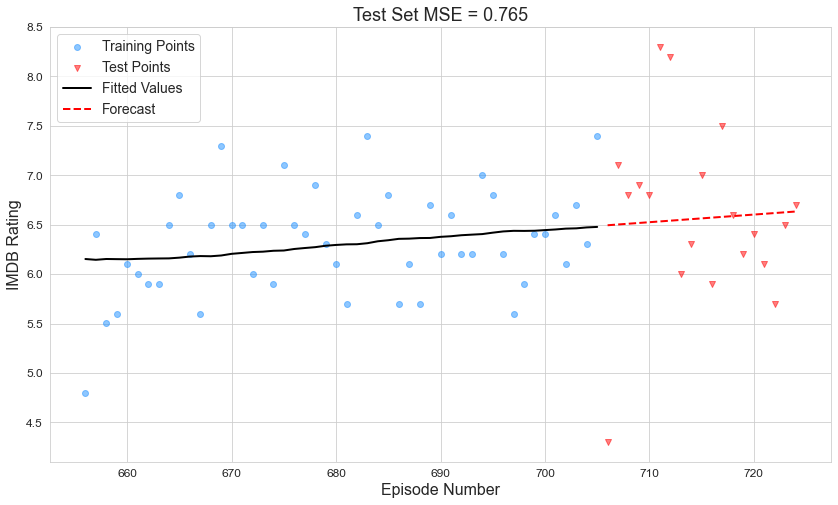

In [23]:
plt.figure(figsize=(14,8))

plt.scatter(range(1, len(simps_train)+1)[-50:],
               simps_train.imdb_rating[-50:],
               alpha=.5,
               c = 'dodgerblue',
               label="Training Points")

plt.scatter(range(len(simps_train)+1, len(simps_train)+len(simps_test)+1),
               simps_test.imdb_rating,
               alpha=.5,
               c = 'red',
               marker = 'v',
               label="Test Points")

plt.plot(range(1, len(simps_train)+1)[-50:],
            exp_smooth.fittedvalues[-50:],
            'k-',
            linewidth = 2,
            label="Fitted Values")

plt.plot(range(len(simps_train)+1, len(simps_train)+len(simps_test)+1),
            exp_smooth.forecast(len(simps_test)),
            'r--',
            linewidth=2,
            label="Forecast")

plt.legend(fontsize=14, loc=2)

plt.title("Test Set MSE = " + str(np.round(mean_squared_error(simps_test.imdb_rating.values, 
                                                     exp_smooth.forecast(len(simps_test))),3)),
             fontsize=18)

plt.xlabel("Episode Number", fontsize=16)
plt.ylabel("IMDB Rating", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2022.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)